# Using a Conditional Generative Adversarial Network to predict V1 Activity

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers, models, losses, optimizers
import os
import time
import datetime
np.random.seed(42)
tf.random.set_seed(45)
from IPython import display


## Preparing the Data

In [3]:
data1 = sio.loadmat('drive/MyDrive/Essay/data/01mean50ms_smallim_d2_crop.mat')
data2 = sio.loadmat('drive/MyDrive/Essay/data/02mean50ms_smallim_d2_crop.mat')
data3 = sio.loadmat('drive/MyDrive/Essay/data/03mean50ms_smallim_d2_crop.mat')
data4 = sio.loadmat('drive/MyDrive/Essay/data/04mean50ms_smallim_d2_crop.mat')
data5 = sio.loadmat('drive/MyDrive/Essay/data/05mean50ms_smallim_d2_crop.mat')
data6 = sio.loadmat('drive/MyDrive/Essay/data/06mean50ms_smallim_d2_crop.mat')
data7 = sio.loadmat('drive/MyDrive/Essay/data/07mean50ms_smallim_d2_crop.mat')
data8 = sio.loadmat('drive/MyDrive/Essay/data/08mean50ms_smallim_d2_crop.mat')
data9 = sio.loadmat('drive/MyDrive/Essay/data/09mean50ms_smallim_d2_crop.mat')
data10 = sio.loadmat('drive/MyDrive/Essay/data/10mean50ms_smallim_d2_crop.mat')

First trying to train on experiment 2 and test on experiment 7

In [322]:
X2 = data2['images']/255.0
y2 = data2['activity'][:, :-1]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2, random_state=42)
X7 = data7['images']/255.0
y7 = data7['activity']

In [5]:
### Encoding Function
def encode_img(image, vector):
    output_img = []
    flat = image.flatten()
    n = image.shape[0]
    m = len(vector)
    for i in range(n**2):
        output_img.append(np.exp(-(flat[i]+vector[i%m])/10))
    output_img = np.array(output_img).reshape(n,n)
    return output_img

In [6]:
# Decoding function
def decode_img(encoded_image, image, m):
    output_vec = []
    encoded_flat = encoded_image.flatten()
    flat = image.flatten()
    for i in range(m):
        output_vec.append(-(10*np.log(encoded_flat[i])+flat[i]))
    return np.array(output_vec)

In [7]:
image = np.arange(0.1,1,0.1).reshape(3,3)
vector = np.array([1,1])
encoded_image = encode_img(image,vector)
decode_img(encoded_image,image,2)

array([1., 1.])

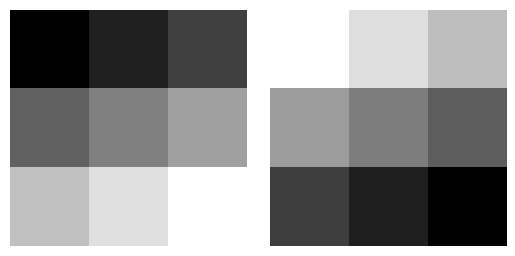

In [259]:
# Create two square matrices (examples)
matrix1 = np.ones((33,33))/255
vector1 = data1["activity"][0]
matrix2 = encode_img(matrix1, vector1)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the first matrix as an image in the first subplot
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')

# Display the second matrix as an image in the second subplot
axes[1].imshow(encoded_image, cmap='gray')
axes[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the figure
plt.show()

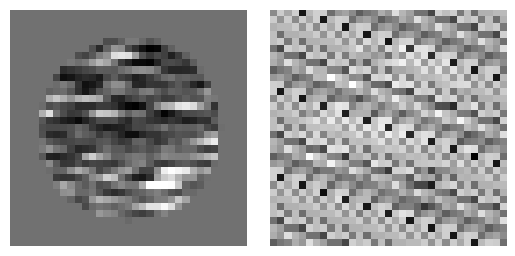

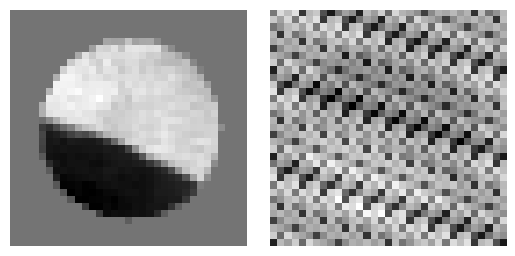

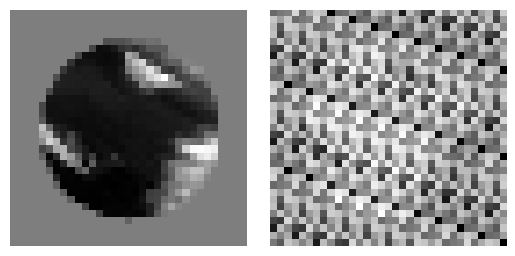

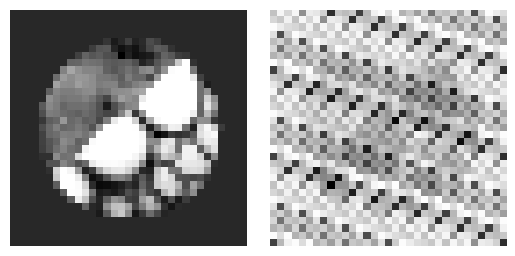

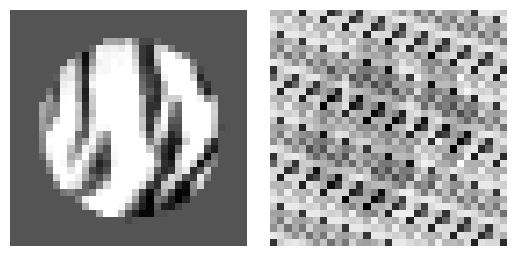

In [323]:
for _ in range(5):
    i = np.random.choice(range(270))
    matrix1 = X2[i]
    vector1 = y2[i]
    matrix2 = encode_img(matrix1, vector1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Display the first matrix as an image in the first subplot
    axes[0].imshow(matrix1, cmap='gray')
    axes[0].axis('off')

    # Display the second matrix as an image in the second subplot
    axes[1].imshow(matrix2, cmap='gray')
    axes[1].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the figure
    plt.show()

In [154]:
BUFFER_SIZE = 216
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 33x3 in size
IMG_WIDTH = 33
IMG_HEIGHT = 33

In [279]:
def load(input_image, real_image):

  # Convert both images to float32 tensors
  input_image = tf.constant(input_image, tf.float32)
  real_image = tf.constant(real_image, tf.float32)

  return input_image, real_image

In [140]:
def resize(input_image, real_image, height, width):
  input_image = tf.expand_dims(input_image, axis=0)
  real_image = tf.expand_dims(real_image, axis=0)
  #input_image = tf.constant(input_image, dtype=tf.float32)
  #real_image = tf.constant(real_image, dtype=tf.float32)
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [149]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image[0], cropped_image[1]

In [150]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 43x43
  input_image, real_image = resize(input_image, real_image, 43, 43)

  # Random cropping back to 33x33
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [115]:
tf.image.flip_left_right?

In [151]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [277]:
def load_image_train(input_image, real_image):
  input_image, real_image = load(input_image, real_image)
  #input_image, real_image = random_jitter(input_image, real_image)
  #input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [280]:
def load_image_test(input_file, real_image):
  input_image, real_image = load(input_file, real_image)
  #input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
  #input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

### Building an input pipeline with tf.data

In [281]:
encoded_train = []
for i in range(len(X_train2)):
    encoded_train.append(encode_img(X_train2[i], y_train2[i]))
input_train_images = []
encoded_train_images = []
for input_image, real_image in zip(X_train2, encoded_train):
  inp, re = load_image_train(input_image, real_image)
  input_train_images.append(inp.numpy())
  encoded_train_images.append(re.numpy())
input_train_images = tf.constant(input_train_images, dtype=tf.float32)
encoded_train_images = tf.constant(encoded_train_images, dtype=tf.float32)
encoded_train_images.shape

TensorShape([216, 33, 33])

In [282]:
encoded_test = []
for i in range(len(X_test2)):
    encoded_test.append(encode_img(X_test2[i], y_test2[i]))
input_test_images = []
encoded_test_images = []
for input_image, real_image in zip(X_test2, encoded_test):
  inp, re = load_image_test(input_image, real_image)
  input_test_images.append(inp.numpy())
  encoded_test_images.append(re.numpy())
input_test_images = tf.constant(input_test_images, dtype=tf.float32)
encoded_test_images = tf.constant(encoded_test_images, dtype=tf.float32)
#encoded_test_images = tf.expand_dims(encoded_test_images, axis=3)
encoded_test_images.shape

TensorShape([54, 33, 33])

In [283]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_train_images, encoded_train_images))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [284]:
test_dataset = tf.data.Dataset.from_tensor_slices((input_test_images, encoded_test_images))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Building an input pipeline with tf.data 1

In [305]:
encoded_train_images = []
for i in range(len(X_train2)):
    encoded_train_images.append(encode_img(X_train2[i], y_train2[i]))
encoded_train_images = np.array(encoded_train_images)
encoded_train_images = tf.constant(encoded_train_images, dtype=tf.float32)
encoded_train_images.shape

TensorShape([216, 33, 33])

In [306]:
encoded_test_images = []
for i in range(len(X_test2)):
    encoded_test_images.append(encode_img(X_test2[i], y_test2[i]))
encoded_test_images = np.array(encoded_test_images)
encoded_test_images = tf.constant(encoded_test_images, dtype=tf.float32)
encoded_test_images.shape

TensorShape([54, 33, 33])

In [307]:
input_train_images = X_train2
input_train_images = tf.cast(input_train_images, tf.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((input_train_images, encoded_train_images))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [308]:
input_test_images = X_test2
input_test_images = tf.cast(input_test_images, tf.float32)
test_dataset = tf.data.Dataset.from_tensor_slices((input_test_images, encoded_test_images))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Building and Training the cGAN

### Generator Network

In [309]:
OUTPUT_CHANNELS = 1

In [310]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [311]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=1,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [344]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[33, 33, 1])

  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
    downsample(512, 3),  # (batch_size, 2, 2, 512)
    downsample(512, 3),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 3),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

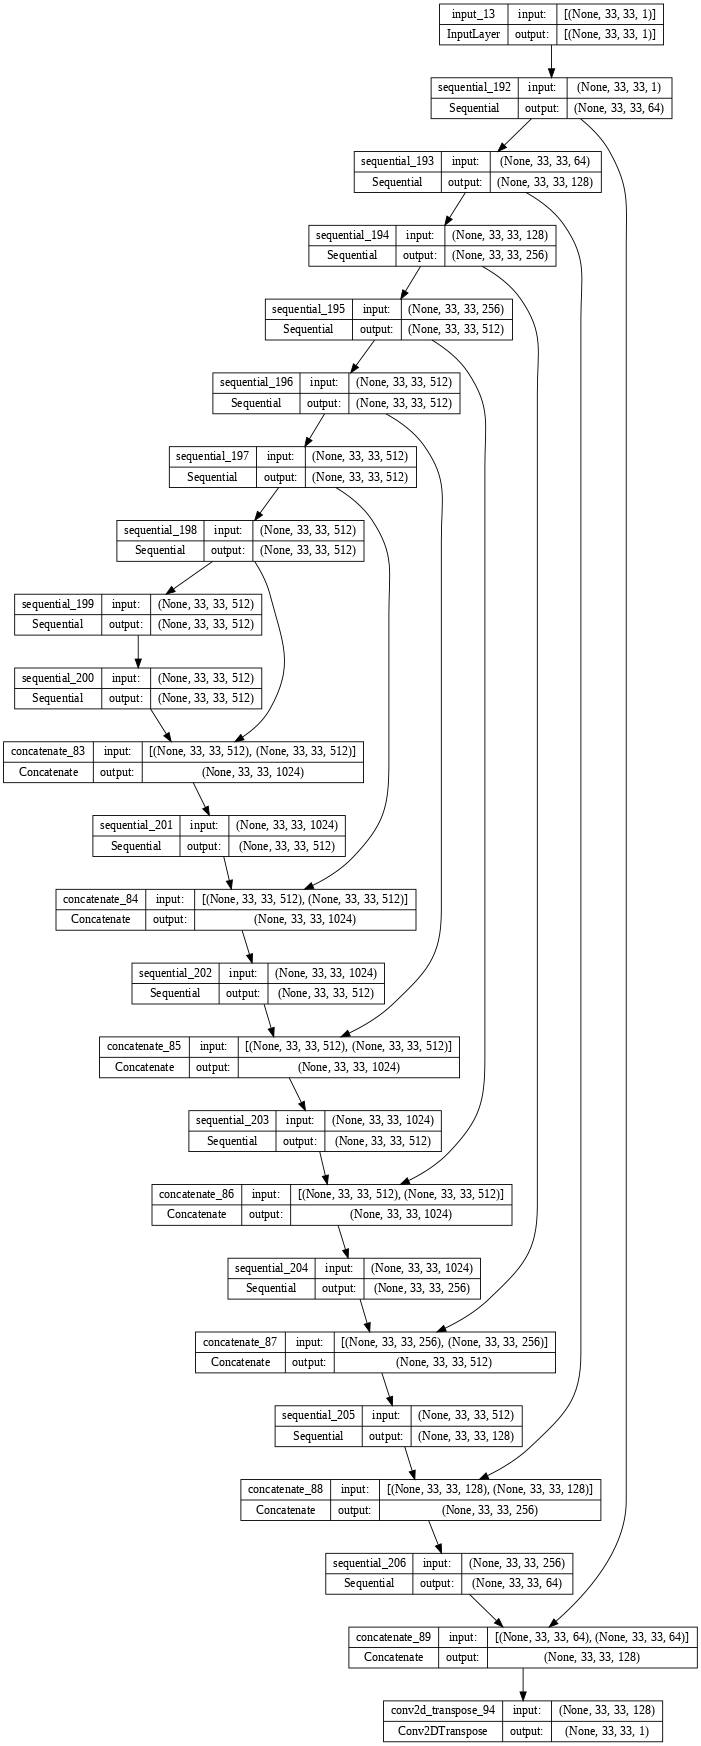

In [363]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Defining the Generator Loss

In [364]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Discriminator Network

In [365]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[33, 33, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[33, 33, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 3, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 3)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 3)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

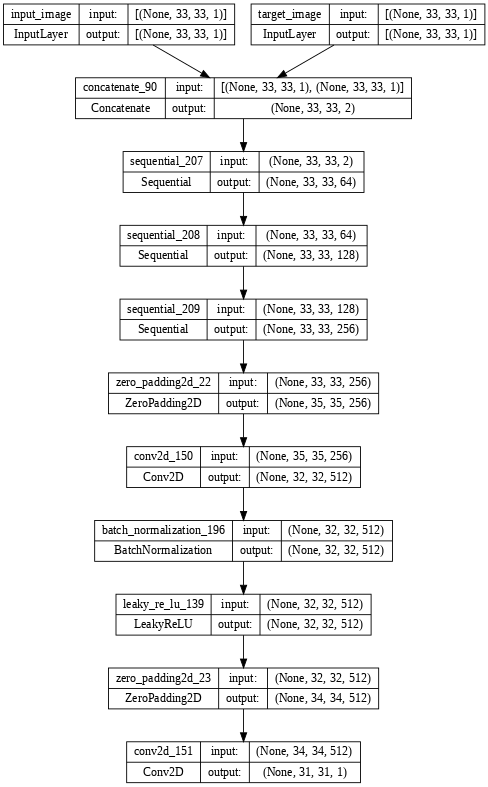

In [366]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Defining the Discriminator Loss

In [367]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Defining the optimizers and a checkpoint-saver

In [352]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Generating images

In [353]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


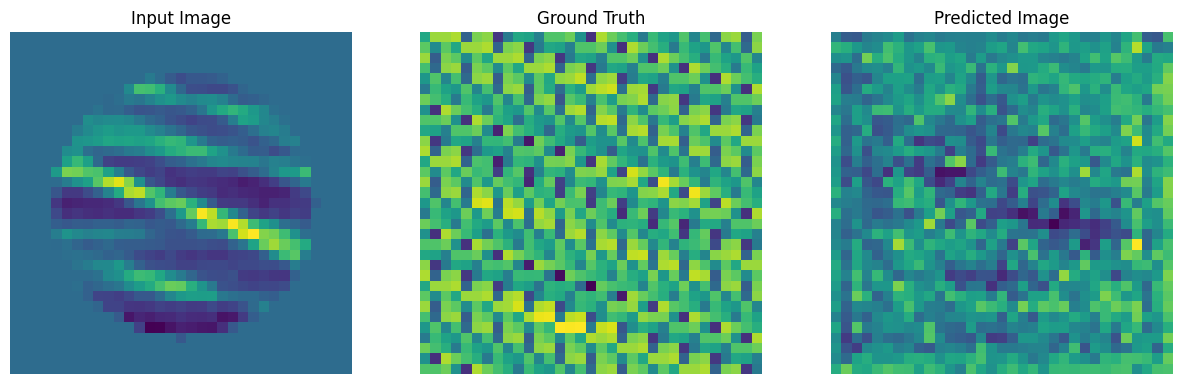

In [354]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### Training the cGAN

In [355]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [356]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    #gen_output = tf.cast(gen_output, tf.float64)

    disc_real_output = discriminator([input_image, target], training=True)
    #disc_real_output = tf.cast(disc_real_output, tf.float64)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    #disc_real_output = tf.cast(disc_real_output, tf.float64)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [357]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

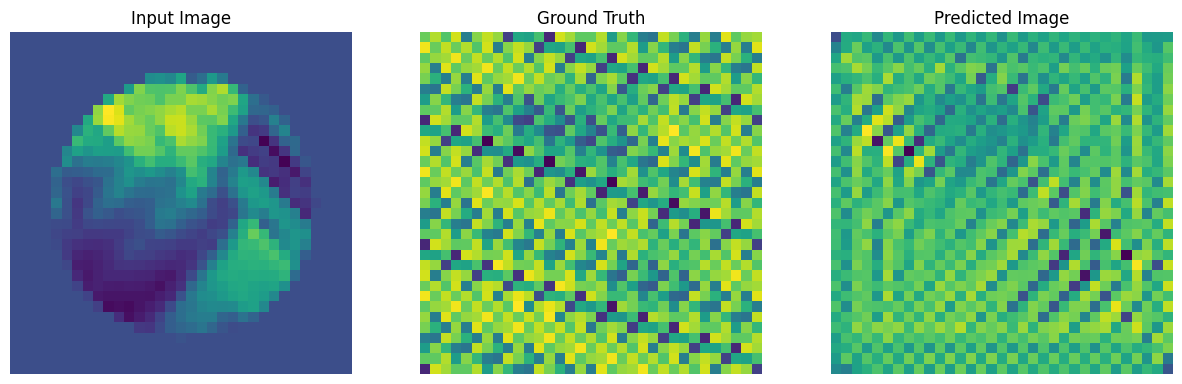

Step: 0k
..................

KeyboardInterrupt: 

In [362]:
fit(train_dataset, test_dataset, steps=300)

## Testing the cGAN

### Plotting input, ground truth and predicted images

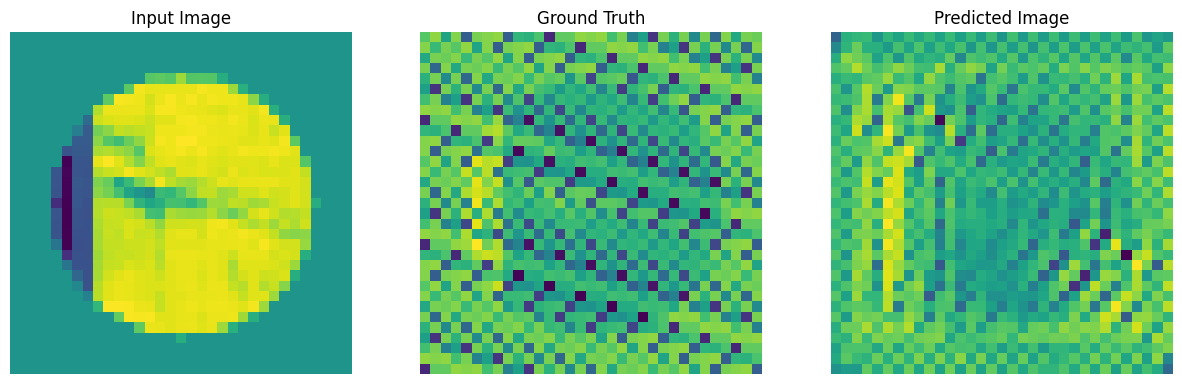

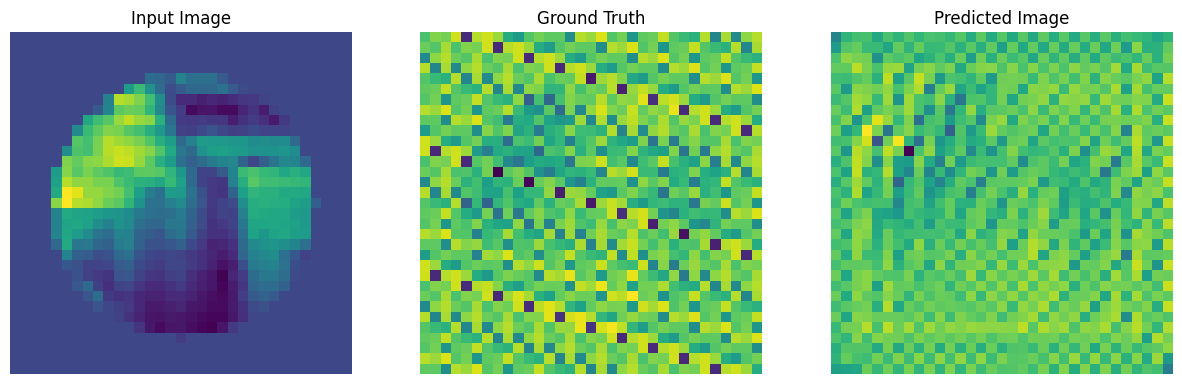

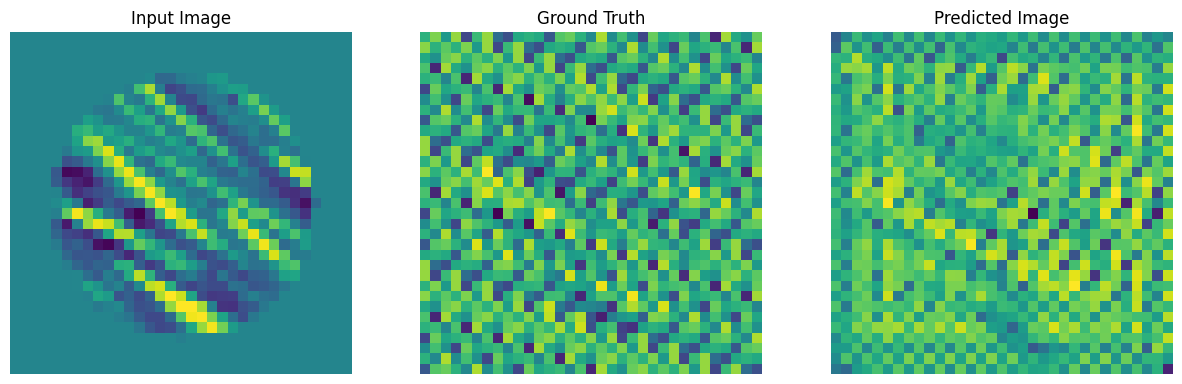

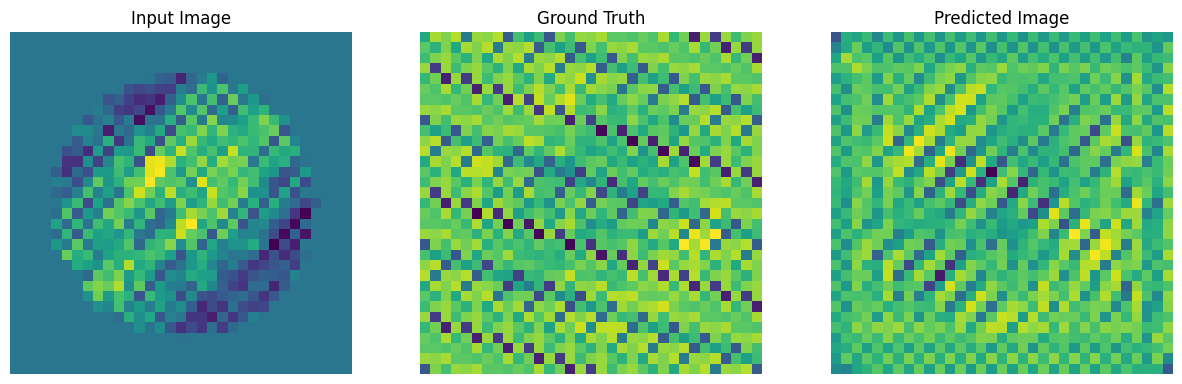

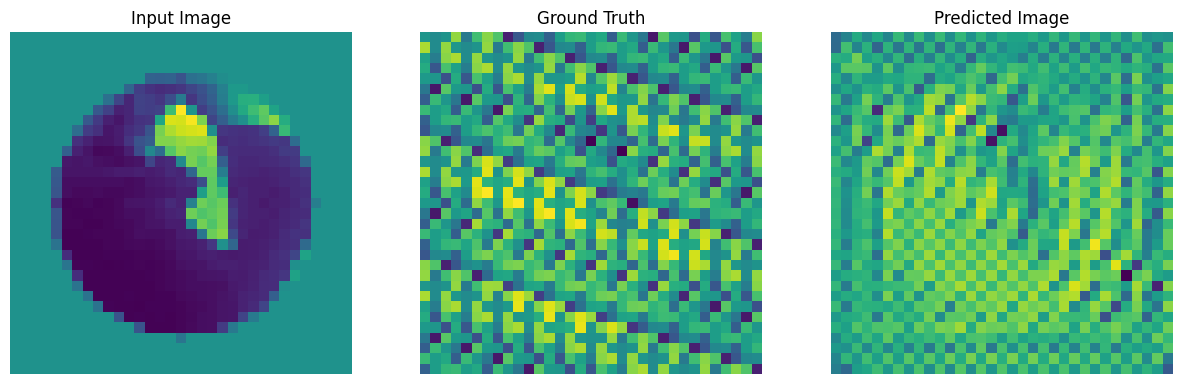

In [359]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

### Plotting actual vs predicted activations

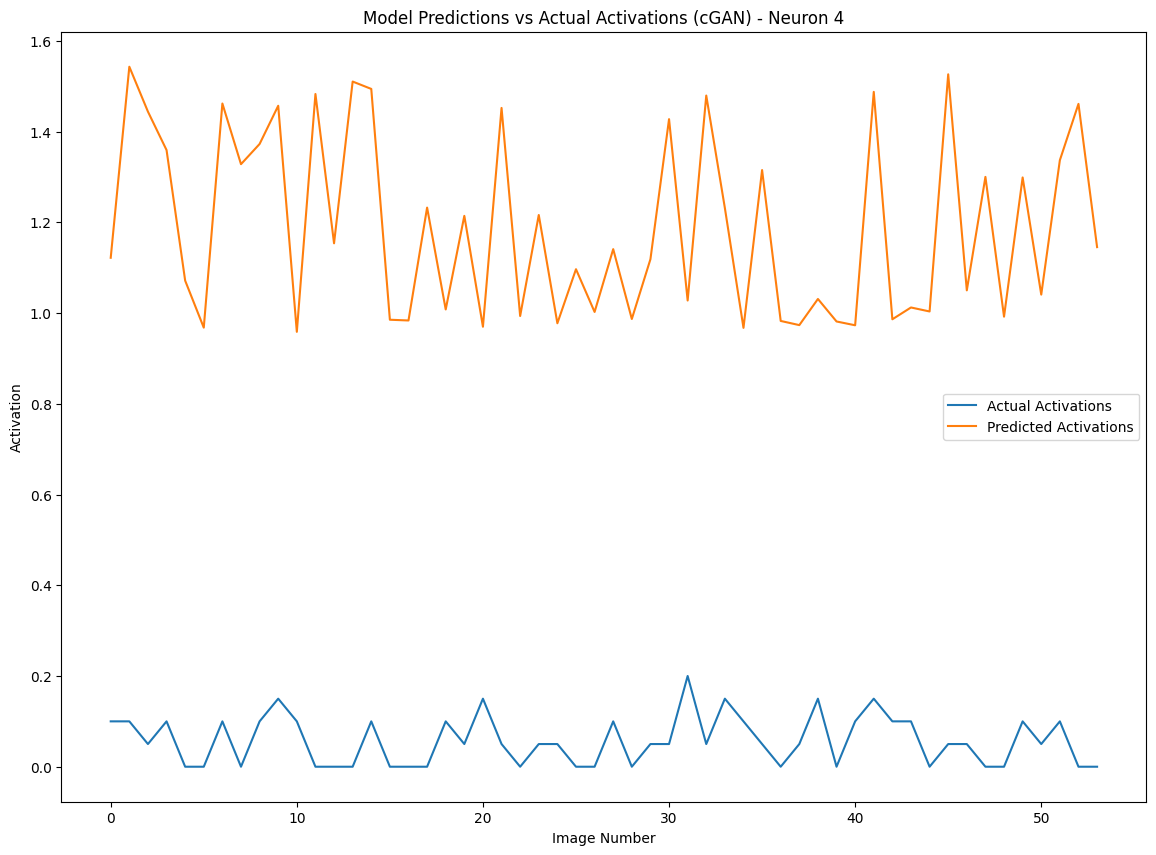

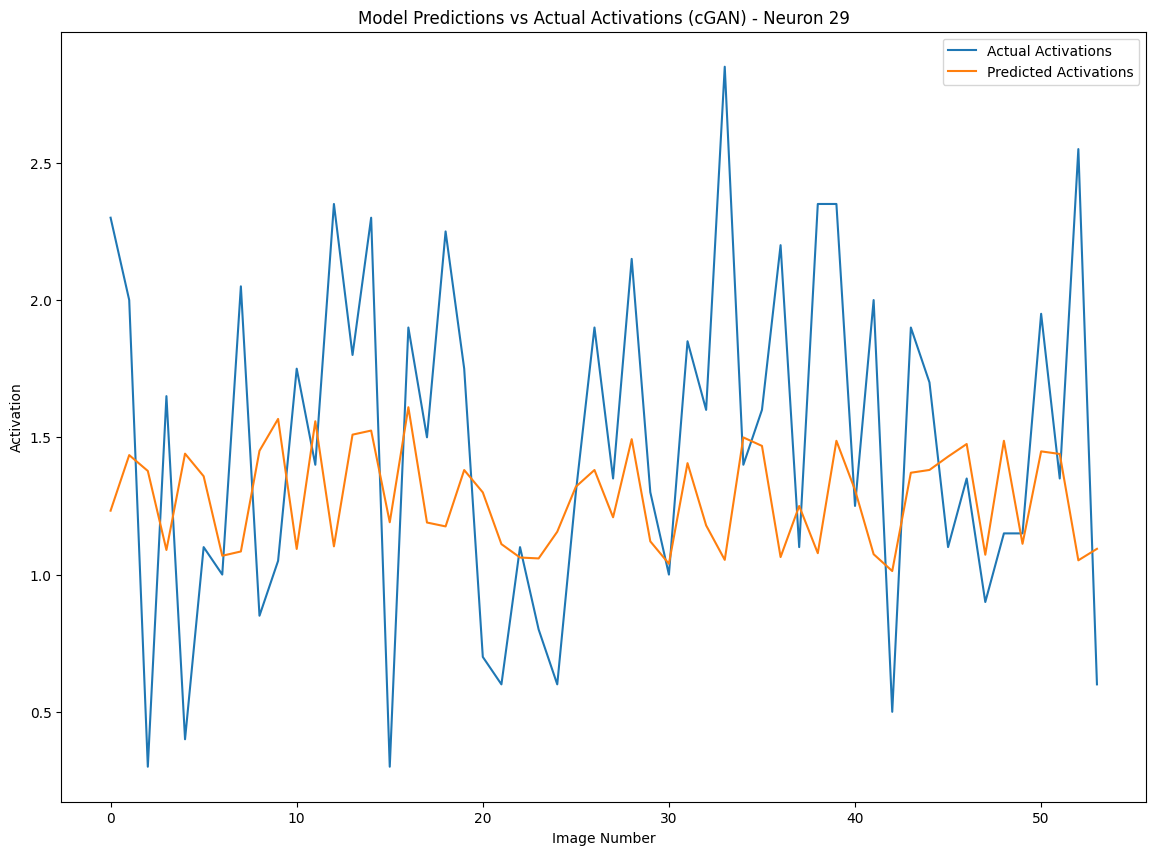

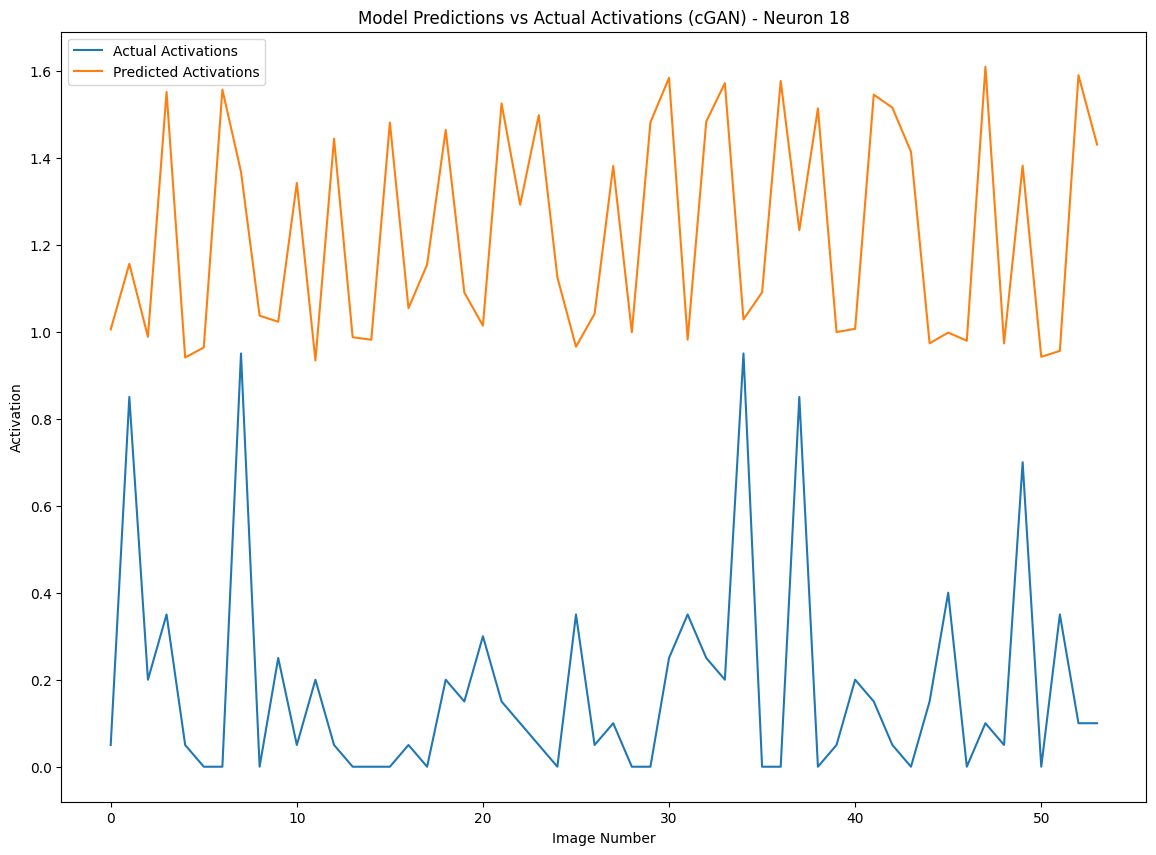

In [360]:
gen_imgs = generator(input_test_images, training=False)
gen_imgs = gen_imgs.numpy().reshape(54,33,33)
pred_vecs = []
m = y_test2.shape[1]
for i in range(y_test2.shape[0]):
  pred_vecs.append(decode_img(gen_imgs[i], X_test2[i], m))
pred_vecs = np.array(pred_vecs)
for _ in range(3):
    index = np.random.choice(range(y_test2.shape[1]))
    yt = y_test2
    y_preds = pred_vecs[:,index]
    plt.figure(figsize=(14,10))
    # Plotting the actual activations
    plt.plot(range(len(yt)), yt[:,index], label='Actual Activations')

    # Plotting the predicted activations
    plt.plot(range(len(y_preds)), y_preds, label='Predicted Activations')

    plt.xlabel('Image Number')
    plt.ylabel('Activation')
    plt.title('Model Predictions vs Actual Activations (cGAN) - Neuron {}'.format(index+1))
    plt.legend()

    plt.show()

In [361]:
def compute_correlation(y_preds, y):
    corrs = []
    for i in range(y.shape[1]):
        corrs.append(np.corrcoef(y_preds[:,i], y[:,i])[0, 1])
    print(len(corrs))
    return np.mean(corrs)
correlation = compute_correlation(pred_vecs, yt)
print("Correlation coefficient:", correlation)

36
Correlation coefficient: 0.01625930265412157
